Since linear models don't capture interactions between features, here, we test for this. This can reveal synergies or antagonisms that have outsized effects on metastatic potential. 

Methodologically, we fit an OLS on regressing the residuals of the model error on the interaction between two features. 

In [1]:
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument("--feature_type", type=str, required=True, help="how to filter features")
# args = parser.parse_args()
# feature_type = args.feature_type

# # python 05_perturbation_interactions_residuals_sets.py --feature_type all 
# # feature_type = 'all' # 'top400', 'enriched'

In [1]:
import os
import itertools
import random
from multiprocessing import Pool
from math import comb

from tqdm import tqdm 

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

import seaborn as sns
import matplotlib.pyplot as plt 

import sys
sys.path.insert(1, '../../')
from utils import read_pickled_object

/nobackup/users/hmbaghda/Software/miniforge3/envs/metastatic_potential/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 3

n_cores = 80
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

# Preprocess

Load data:

In [57]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
expr_joint = X.copy()

mp_joint=pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean']
y = mp_joint.values.ravel()

expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)

protein_cols = expr_protein.columns
rna_cols = expr_rna.columns

X_protein = X[protein_cols].values
X_rna = X[rna_cols].values


As in [Notebook 04](./04_feature_analysis.ipynb), we fit the consensus linear SVR on the entire dataset:

In [5]:
best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 
                                                 'best_model_svr_linear_joint.pickle'))
X = (X_protein, X_rna)
best_pipeline.fit(X, y)

# load from notebook 04
# best_pipeline = read_pickled_object(os.path.join(data_path, 'interim', 'best_linearSVR_joint_fitted_allsamples.pickle'))


Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('protein_pipeline',
                                                 Pipeline(steps=[('select_protein',
                                                                  ModalitySelector(modality='protein')),
                                                                 ('feature_selection_protein',
                                                                  FeatureSelector(n_features=500)),
                                                                 ('mean_centering_protein',
                                                                  MeanCenterer())])),
                                                ('rna_pipeline',
                                                 Pipeline(steps=[('select_rna',
                                                                  ModalitySelector(modality='rna')),
                                                                 ('feature_selection_rna',
                                                                  FeatureSelector(n_features=19138)),
                                                                 ('mean_centering_rna',
                                                                  MeanCenterer())]))])),
                ('model',
                 SVR(C=np.float64(0.8708199642350806),
                     epsilon=np.float64(0.7444800190713263),
                     kernel='linear'))])

In [6]:
model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
if not np.allclose(model_coefs['SVM coefficient'].values, 
                   best_pipeline.named_steps['model'].coef_.flatten()):
    raise ValueError('Inconsitency between Notebook 04 and 05')
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.set_index('feature_name', inplace = True)


Get the prediction:

In [7]:
# get prediction
y_pred = best_pipeline.predict(X)
residuals = y - y_pred

Center the data:

In [20]:
# Start

In [6]:
# X_map = {'Transcriptomics': X_rna, 'Proteomics': X_protein}
# X_map = {k: X_ - np.mean(X_, axis=0) for k, X_ in X_map.items()} # center the data

expr_rna

In [58]:
expr_joint.columns = [x.split(' (')[0] for x in expr_joint.columns]

In [59]:
expr_joint_centered = expr_joint - expr_joint.mean(axis = 0)

In [70]:
np.ptp(expr_joint.loc[:, feature])

np.float64(3.684867595459795)

<Axes: xlabel='SP1', ylabel='Count'>

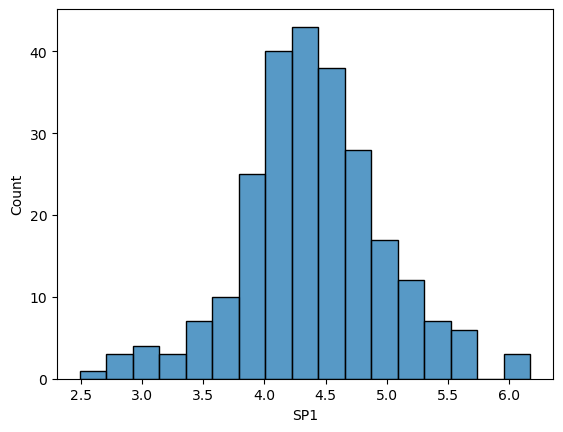

In [69]:
feature = 'SP1'
sns.histplot(expr_joint.loc[:, feature])




In [74]:
np.min(expr_joint.loc[:, feature])

np.float64(2.489980948178384)

In [75]:
np.max(expr_joint.loc[:, feature])

np.float64(6.174848543638179)

In [ ]:
np.min(expr_joint_centered.loc[:, feature])

<Axes: xlabel='SP1', ylabel='Count'>

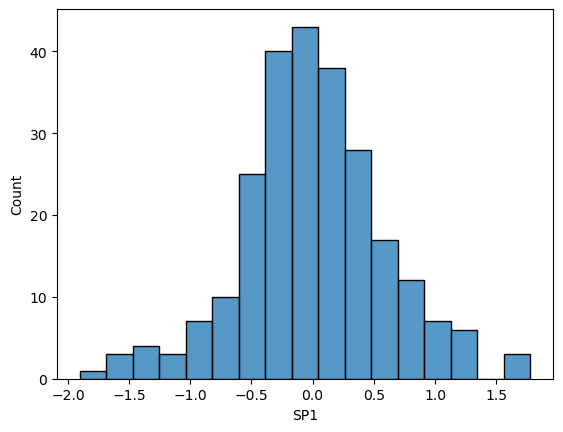

In [67]:
feature = 'SP1'
sns.histplot(expr_joint_centered.loc[:, feature])

In [76]:
best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 
                                                 'best_model_svr_linear_joint.pickle'))

In [79]:
best_pipeline.__dict__.keys()

dict_keys(['steps', 'memory', 'verbose'])

In [83]:
best_pipeline.steps

[('feature_processing',
  FeatureUnion(transformer_list=[('protein_pipeline',
                                  Pipeline(steps=[('select_protein',
                                                   ModalitySelector(modality='protein')),
                                                  ('feature_selection_protein',
                                                   FeatureSelector(n_features=500)),
                                                  ('mean_centering_protein',
                                                   MeanCenterer())])),
                                 ('rna_pipeline',
                                  Pipeline(steps=[('select_rna',
                                                   ModalitySelector(modality='rna')),
                                                  ('feature_selection_rna',
                                                   FeatureSelector(n_features=19138)),
                                                  ('mean_centering_rna',
             

# End

In [8]:
X_map = {'Transcriptomics': X_rna, 'Proteomics': X_protein}
X_map = {k: X_ - np.mean(X_, axis=0) for k, X_ in X_map.items()} # center the data

# # center and scale the data
# from sklearn.preprocessing import StandardScaler
# for k, X_ in X_map.items():
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X_)
#     X_map[k] = X_scaled
    
# for k, X_ in X_map.items():
#     X_centered = X_ - np.mean(X_, axis=0) # mean center
#     X_map[k] = X_centered
#     X_scaled = X_centered / np.std(X_, axis=0) # scale
#     X_map[k] = X_scaled

# Top Genes

Let's see whether there are interactions between the top 25, 50, or 100 features ranked by the model coefficient:

In [9]:
def get_interaction_value(feature_1: str, feature_2: str, residuals, X_map, model_coefs):
    X_1 = X_map[model_coefs.loc[feature_1,'Modality']][:, model_coefs.loc[feature_1, 'feature_index']]
    X_2 = X_map[model_coefs.loc[feature_2,'Modality']][:, model_coefs.loc[feature_2, 'feature_index']]

    ols_df = pd.DataFrame({"residual": residuals, 
                           "X_tilda": X_1 * X_2})

    ols_interaction = smf.ols("residual ~ X_tilda", data=ols_df).fit()


    coef = float(ols_interaction.params.X_tilda)
    pval = float(ols_interaction.pvalues.X_tilda)
    
    se = ols_interaction.bse.X_tilda
    
    t_statistic = float(abs(coef))/se
    
    return coef, pval, t_statistic

In [16]:
alpha = 0.2
top_n_res = {}
for top_n in [25, 50, 100]:
    features = model_coefs.index.tolist()[:top_n]
    feature_combs = list(itertools.combinations(features, 2))
    
    res_all = []
    for feature_comb in tqdm(feature_combs):
        res = get_interaction_value(feature_comb[0], feature_comb[1], residuals, X_map, model_coefs)[:-1]
        res_all.append(res)

    res_all = pd.DataFrame(res_all, columns = ['coef', 'pval'])
    _, bh_fdr, _, _ = multipletests(res_all.pval, method='fdr_bh')
    res_all['bh_fdr'] = bh_fdr

    res_all = pd.concat([
        pd.DataFrame(feature_combs, columns = ['feature_1', 'feature_2']),
        res_all
    ],
        axis = 1)
    
    n_sig_hits = res_all[res_all.bh_fdr <= alpha].shape[0]
    
    print('Considering the top {} genes, there are {} significant interactions out of a possible {}'.format(top_n, 
                                                                                                            n_sig_hits, 
                                                                                                            comb(top_n, 2)))

    top_n_res[top_n] = res_all

100%|██████████████████████████████████████████| 300/300 [00:01<00:00, 172.98it/s]


Considering the top 25 genes, there are 0 significant interactions out of a possible 300


100%|████████████████████████████████████████| 1225/1225 [00:07<00:00, 174.28it/s]


Considering the top 50 genes, there are 0 significant interactions out of a possible 1225


100%|████████████████████████████████████████| 4950/4950 [00:28<00:00, 174.61it/s]

Considering the top 100 genes, there are 0 significant interactions out of a possible 4950


We see that amongst the top ranked genes, there are no significant interactions. However, it is possible for interactions to occur non-intuitively across features that don't have high ranks. So, in the next notebook, let's use a genetic algorithm identify highly interacting genes. 